In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [171]:
import pandas as pd
import numpy as np
from bayesian.train_bn import structure_learning, parameter_learning, parameter_learning_mix
from preprocess.discretization import get_nodes_type, discretization, inverse_discretization, code_categories
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN
from bayesian.calculate_accuracy import calculate_acc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from copy import copy
from external.libpgm.sampleaggregator import SampleAggregator
import operator
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
import math
from pomegranate import DiscreteDistribution
import random
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from scipy.stats.distributions import chi2
import time

In [50]:
geo = pd.read_csv('../datasets/hackathon_processed.csv')
columns = ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Hydrocarbon type', 'Gross','Netpay','Porosity','Permeability', 'Depth']
geo = geo[columns]
geo.dropna(inplace=True)
geo.reset_index(inplace=True, drop=True)

In [44]:
def mix_norm_cdf(x, weights, means, covars):
    mcdf = 0.0
    for i in range(len(weights)):
        mcdf += weights[i] * stats.norm.cdf(x, loc=means[i][0], scale=covars[i][0][0])
    return mcdf

In [147]:
def quantile_mix(p, data, n_comp):
    model = GaussianMixture(n_components=n_comp)
    model.fit(data)
    q = []
    x = []
    for i in range (int(np.min(model.sample(100000)[0])), int(np.max(model.sample(100000)[0])), 10):
        x.append(i)
        q.append(mix_norm_cdf(i,model.weights_, model.means_, model.covariances_))
    ind = q.index(min(q, key=lambda x:abs(x-p)))
    return(x[ind])


In [148]:
def sum_dist(data, n_comps):
    percs = np.linspace(1, 100, 10)
    x = np.quantile(data, percs/100)
    y = []
    for q in percs:
        y.append(quantile_mix(q/100, data, n_comps))
    dist = 0
    for xi,yi in zip(x,y):
        dist = dist + (abs(-1*xi + yi)) / math.sqrt(2)
    return dist

In [267]:
data = np.transpose([geo['Gross'].values])

In [268]:
dists = []
for i in range (1, 11 ,1):
    dists.append(sum_dist(data, i))

([<matplotlib.axis.XTick at 0x20c7caaa610>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10')])

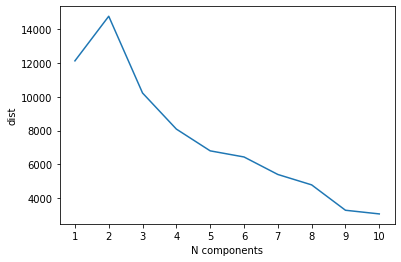

In [269]:
plt.plot([i for i in range(1,11,1)], np.transpose(dists))
plt.xlabel('N components')
plt.ylabel('dist')
plt.xticks([(i+1) for i in range (10) ], [(i+1) for i in range (10) ])

In [270]:
diff = []
label = []
for i in range(9):
    label.append('c1='+str(i+1)+' c2='+str(i+2))
    diff.append(dists[i] - dists[i+1])


Text(0, 0.5, 'Difference')

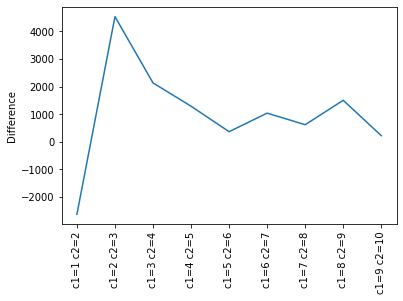

In [271]:
plt.plot(label, diff)
plt.xticks(rotation=90)
plt.ylabel('Difference')

In [274]:
def n_comp_quantile (data):
    n = 1
    dists = []
    for i in range(10):
        dists.append(sum_dist(data, i+1))
    diff = []
    for i in range(9):
        diff.append(dists[i] - dists[i+1])
    n = diff.index(max(diff)) +2
    return n


In [123]:
def BIC (LL, n_components, n):
    return (LL - ((0.5)*math.log(n)*(n_components-1 + 2*n_components)))

In [124]:
def AIC (LL,n_components):
    return (LL - (n_components-1 + 2*n_components))

In [130]:
def LRTS(data):
    n = 0
    for i in range (1, 20, 1):
        gm1 = GaussianMixture(n_components=i, random_state=0)
        gm2 = GaussianMixture(n_components=i+1, random_state=0)
        gm1.fit(data)
        ll1 = np.sum(gm1.score_samples(data))
        gm2.fit(data)
        ll2 = np.sum(gm2.score_samples(data))
        LR = 2*(ll2 - ll1)
        p = chi2.sf(LR, 1)    
        if p <= 0.05:
            continue
        else:
            n = i
            break
    return n

In [126]:
def n_component(data: pd.DataFrame, columns: list, method: str = 'BIC'):
    n = 1
    x = []
    if len(columns) == 1:
        x = np.transpose([data[columns[0]].values])
    else:
        x = data[columns].values
    if method == 'BIC':
        bic = -1000000000000000
        for i in range(1, 20, 1):
            gm = GaussianMixture(n_components=i, random_state=0)
            gm.fit(x)
            ll_current = np.sum(gm.score_samples(x))  
            bic_current = (BIC(ll_current, i, data.shape[0]))
            if bic_current > bic:
                bic = bic_current
                n = i
            else:
                break
    if method == 'AIC':
        aic = -1000000000000000
        for i in range(1, 20, 1):
            gm = GaussianMixture(n_components=i, random_state=0)
            gm.fit(x)
            ll_current = np.sum(gm.score_samples(x))  
            aic_current = (AIC(ll_current, i))
            if aic_current > aic:
                aic = aic_current
                n = i
            else:
                break
    if method == 'LRTS':
        n = LRTS(x)
    if method == 'quantile':
        n = n_comp_quantile(x)
    return(n)

In [170]:
methods = ['BIC', 'AIC', 'LRTS', 'quantile']
cont_columns = ['Gross','Netpay','Porosity','Permeability', 'Depth']
times = [[] for i in range(4)]

In [172]:
for ind, m in enumerate(methods):
    for c in cont_columns:
        start = time.time()
        n = n_component(geo, [c], m)
        end = time.time()
        times[ind].append(end-start)

In [174]:
t = pd.DataFrame()
t['time'] = times[0]
t['method'] = ['BIC' for i in range(5)]

In [176]:
t1 = pd.DataFrame()
t1['time'] = times[1]
t1['method'] = ['AIC' for i in range(5)]

In [177]:
t2 = pd.DataFrame()
t2['time'] = times[2]
t2['method'] = ['LRTS' for i in range(5)]

In [178]:
t3 = pd.DataFrame()
t3['time'] = times[3]
t3['method'] = ['Quantile' for i in range(5)]

In [183]:
all_times = pd.concat([t,t1,t2, t3])

Text(0.5, 0, 'Method')

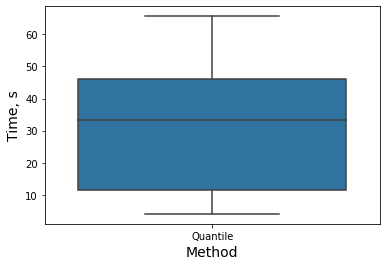

In [185]:
sns.boxplot(x="method", 
            y="time", 
            data=t3)
plt.ylabel("Time, s", size=14)
plt.xlabel("Method", size=14)

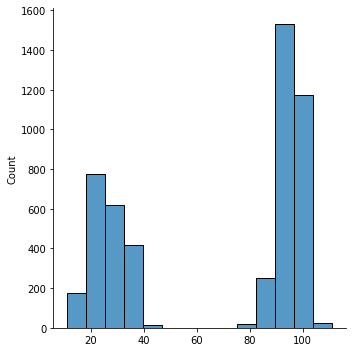

In [277]:
data = []
n = 5
mu = [random.randint(0,100) for i in range(n)]
sigma = [random.randint(0,5) for i in range(n)]
for _ in range(1000):
    for __ in range(n):
        data.append(random.gauss(mu[__], sigma[__]))
sns.displot(data)

In [278]:
x = pd.DataFrame()
x['data'] = data

In [279]:
n_component(x, ['data'], 'quantile')

2